[View in Colaboratory](https://colab.research.google.com/github/kundajelab/igsvm/blob/master/lsgkmexplain_TALGATA.ipynb)

In [1]:
#install lsgkm
!rm -r lsgkm
! git clone https://github.com/kundajelab/lsgkm
% cd lsgkm/src
! make
! ./gkmtrain
%cd ../..

rm: cannot remove 'lsgkm': No such file or directory
Cloning into 'lsgkm'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 254 (delta 94), reused 85 (delta 45), pack-reused 111
Receiving objects: 100% (254/254), 514.90 KiB | 2.67 MiB/s, done.
Resolving deltas: 100% (159/159), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmpredict.c libsvm.o libsvm_gkm.o -o gkmpredict -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmexplain.c libsvm.o libsvm_gkm.o -o gkmexplain -lm -lpthread

Usage: gkmtrain [options] <posfile> <negfile> <outprefix>

 train gkm-SVM using libSVM

Arguments:
 posfile: positive sequence file (FASTA format)
 negfile: negative sequence file (FASTA format)
 outprefix: prefi

In [2]:
#get the raw data
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/master/deeplift/genomics/sequences.simdata.gz

--2018-10-16 08:04:48--  https://raw.githubusercontent.com/AvantiShri/model_storage/master/deeplift/genomics/sequences.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629502 (615K) [application/octet-stream]
Saving to: ‘sequences.simdata.gz’

sequences.simdata.g 100%[===================>] 614.75K  --.-KB/s    in 0.06s   

2018-10-16 08:04:48 (10.1 MB/s) - ‘sequences.simdata.gz’ saved [629502/629502]



In [3]:
!zcat sequences.simdata | head

seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATATAAAATAGTAGTAA

In [0]:
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "1") {print ">$F[0]\n$F[1]"}' > positives.fa
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "0") {print ">$F[0]\n$F[1]"}' > negatives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' positives.fa > test_positives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' positives.fa > train_positives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' negatives.fa > test_negatives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' negatives.fa > train_negatives.fa

In [5]:
!wc -l *.fa

  12000 negatives.fa
   4000 positives.fa
   2400 test_negatives.fa
    800 test_positives.fa
   9600 train_negatives.fa
   3200 train_positives.fa
  32000 total


In [6]:
import time

t=3
c=10
g=2
l=6
k=5
d=1

!lsgkm/src/gkmtrain -t $t -c $10 -g $2 -l $l -k $k -d $d -w 3 train_positives.fa train_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3"


start = time.time()
!lsgkm/src/gkmpredict test_positives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_positives.txt
end = time.time()
print("Time taken per seq:",(end-start)/400)
start = time.time()
!lsgkm/src/gkmpredict test_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_negatives.txt
end = time.time()
print("Time taken per seq:",(end-start)/1200)

import numpy as np
from sklearn.metrics import roc_auc_score
pos_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_positives.txt")]
neg_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_negatives.txt")]
print(roc_auc_score(y_true=np.array([1 for i in range(len(pos_preds))]+[0 for i in range(len(neg_preds))]),
                    y_score=np.array(pos_preds+neg_preds)))

INFO 2018-10-16 08:04:57: Number of threads is set to 1
INFO 2018-10-16 08:04:57: Arguments:
INFO 2018-10-16 08:04:57:   posfile = train_positives.fa
INFO 2018-10-16 08:04:57:   negfile = train_negatives.fa
INFO 2018-10-16 08:04:57:   outprefix = params_t3_l6_k5_d1_g2_c10_w3
INFO 2018-10-16 08:04:57: Parameters:
INFO 2018-10-16 08:04:57:   kernel-type = 3
INFO 2018-10-16 08:04:57:   L = 6
INFO 2018-10-16 08:04:57:   k = 5
INFO 2018-10-16 08:04:57:   d = 1
INFO 2018-10-16 08:04:57:   gamma = 2
INFO 2018-10-16 08:04:57:   C = 10
INFO 2018-10-16 08:04:57:   w = 3
INFO 2018-10-16 08:04:57:   eps = 0.001
INFO 2018-10-16 08:04:57:   shrinking = no
INFO 2018-10-16 08:04:57: reading 1600 sequences from train_positives.fa
INFO 2018-10-16 08:04:57: reading... 0
INFO 2018-10-16 08:04:57: reading... 1000
INFO 2018-10-16 08:04:57: reading... done
INFO 2018-10-16 08:04:57: reading 4800 sequences from train_negatives.fa
INFO 2018-10-16 08:04:57: reading... 0
INFO 2018-10-16 08:04:57: reading... 1000


In [7]:
import time
model_file = "params_t"+str(t)+"_l"+str(l)+"_k"+str(k)+"_d"+str(d)+"_g"+str(g)+"_c"+str(c)+"_w3.model.txt"

!head $model_file

print("Computing actual contributions")
start = time.time()
!lsgkm/src/gkmexplain test_positives.fa $model_file explanation_positives.txt
end = time.time()
print("time taken per seq",(end-start)/400)

print("Computing hypothetical contributions")
print("This is a lot slower than the actual contributions."
      " Skip this if you are not interested in motif discovery")
start = time.time()
!lsgkm/src/gkmexplain -m 1 test_positives.fa $model_file hyp_explanation_positives.txt
end = time.time()
print("time taken per seq",(end-start)/400)

svm_type c_svc
kernel_type gkmrbf
L 6
k 5
d 1
gamma 2
nr_class 2
total_sv 4452
rho 2.29412
label 1 -1
Computing actual contributions
INFO 2018-10-16 08:05:27: Number of threads is set to 1
INFO 2018-10-16 08:05:27: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-16 08:05:27: reading... 1000/4452
INFO 2018-10-16 08:05:27: reading... 2000/4452
INFO 2018-10-16 08:05:27: reading... 3000/4452
INFO 2018-10-16 08:05:27: reading... 4000/4452
INFO 2018-10-16 08:05:27: write prediction result to explanation_positives.txt
INFO 2018-10-16 08:05:42: 100 scored
INFO 2018-10-16 08:05:57: 200 scored
INFO 2018-10-16 08:06:11: 300 scored
INFO 2018-10-16 08:06:26: 400 scored
time taken per seq 0.14849353909492494
Computing hypothetical contributions
This is a lot slower than the actual contributions. Skip this if you are not interested in motif discovery
INFO 2018-10-16 08:06:26: Number of threads is set to 1
INFO 2018-10-16 08:06:26: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 

In [8]:
print("Computing hypothetical contributions")
print("This is a lot slower than the actual contributions."
      " Skip this if you are not interested in motif discovery")
start = time.time()
!lsgkm/src/gkmexplain -m 1 test_positives.fa $model_file hyp_explanation_positives.txt
end = time.time()
print("time taken per seq",(end-start)/400)

Computing hypothetical contributions
This is a lot slower than the actual contributions. Skip this if you are not interested in motif discovery
INFO 2018-10-16 08:09:07: Number of threads is set to 1
INFO 2018-10-16 08:09:07: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-16 08:09:07: reading... 1000/4452
INFO 2018-10-16 08:09:07: reading... 2000/4452
INFO 2018-10-16 08:09:07: reading... 3000/4452
INFO 2018-10-16 08:09:07: reading... 4000/4452
INFO 2018-10-16 08:09:08: write prediction result to hyp_explanation_positives.txt
INFO 2018-10-16 08:09:47: 100 scored
INFO 2018-10-16 08:10:26: 200 scored
INFO 2018-10-16 08:11:06: 300 scored
INFO 2018-10-16 08:11:45: 400 scored
time taken per seq 0.3984046667814255


In [0]:
import numpy as np

impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("explanation_positives.txt")
]

hyp_impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("hyp_explanation_positives.txt")
]

import numpy as np
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("test_positives.fa"))
              if i%2==1]
onehot_data = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])

  Running setup.py bdist_wheel for deeplift ... - \ done
  Stored in directory: /root/.cache/pip/wheels/de/c4/b0/ec9deaa25dfaad60ad234f1d17b0339a8a9f5bfe4d7de42edd
Successfully built deeplift
-0.6464163029000001
0.0


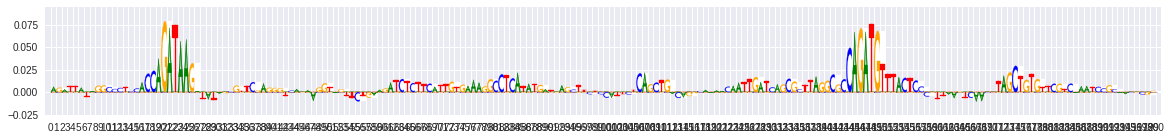

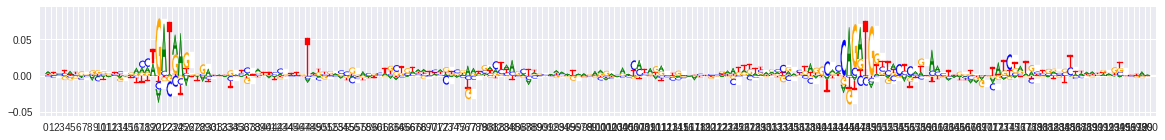

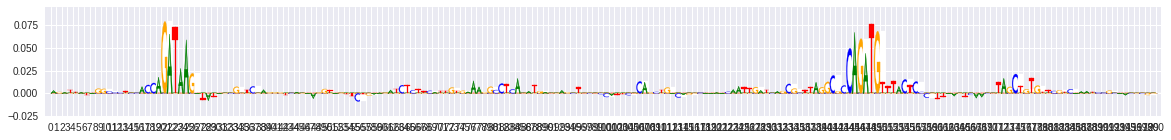

0.04206151120000001
0.0


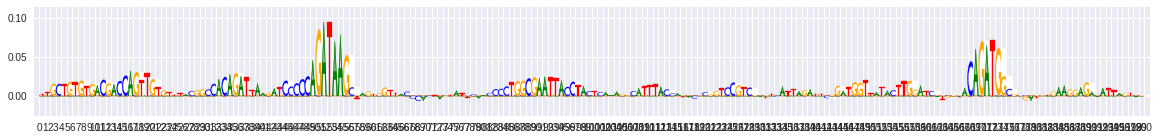

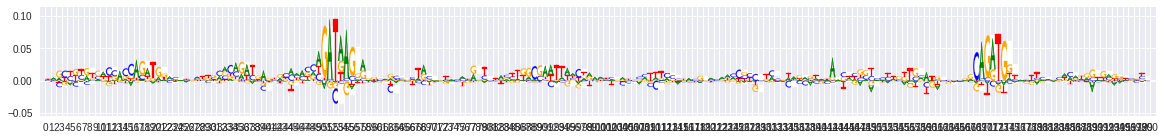

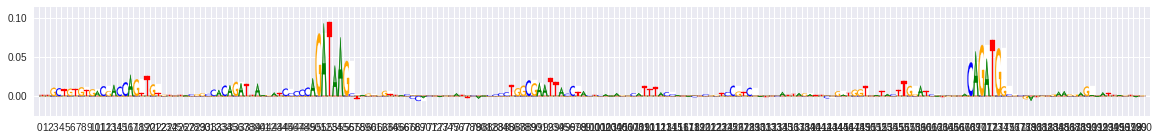

0.26993512899999983
0.0


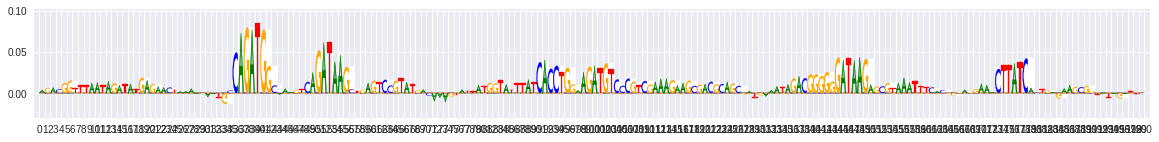

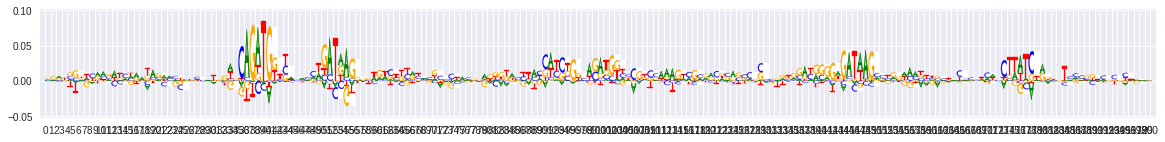

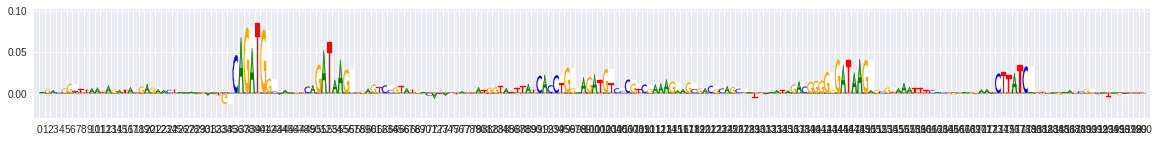

In [10]:
!pip install deeplift

from deeplift.visualization import viz_sequence
for i in range(3):
  print(np.sum(impscores[i]) - 2.53961)
  print(np.sum(np.abs(hyp_impscores[i]*onehot_data[i] - impscores[i])))
  viz_sequence.plot_weights(impscores[i])
  
  
  #normalize the hyp scores such that, at each position, hypothetical importance
  # scores that have the same sign as the original importance score all sum
  # up to the original importance score value. The rationale is that if
  # a different base at the same position could produce a score of higher
  # magnitude than the base that is actually present, then the base
  # that is actually present is relatively less important.
  #Empirically, hypothetical scores like these appear to work better for
  # motif discovery.
  imp_score_each_pos = np.sum(impscores[i],axis=-1)
  imp_score_sign_each_pos = np.sign(imp_score_each_pos)
  hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])*imp_score_sign_each_pos[:,None] > 0)
  #print(hyp_scores_same_sign_mask)
  hyp_scores_same_sign_imp_scores_sum = np.sum(hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
  norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
  #print(hyp_scores_same_sign_imp_scores_sum)
  norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
  
  viz_sequence.plot_weights(norm_hyp)
  viz_sequence.plot_weights(norm_hyp*onehot_data[i])


# Motif discovery with TF-MoDISco

In [11]:
#Install TF-MoDISco

!rm -rf tfmodisco
!git clone https://github.com/kundajelab/tfmodisco.git
%cd tfmodisco
#Checkout a specific commit for reproducibility
#!git checkout d6b2d1fc7dd908a79edc90d981edc7bfd36779f6
!git checkout v0.4.2.2-alpha
!pip install .
%cd ..

Cloning into 'tfmodisco'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 2513 (delta 10), reused 20 (delta 6), pack-reused 2483
Receiving objects: 100% (2513/2513), 31.83 MiB | 27.42 MiB/s, done.
Resolving deltas: 100% (1641/1641), done.
/content/tfmodisco
Note: checking out 'v0.4.2.2-alpha'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at e5268ab Update setup.py
Processing /content/tfmodisco
  Running setup.py bdist_wheel for modisco ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-1vrogqag/wheels/37/3

TF-MoDISco is using the TensorFlow backend.


On task task0
Computing windowed sums
Computing threshold
peak(mu)= 0.008778671362325532
Manually adjusting thresholds to get desired num seqlets
Mu: 8.778671e-03 +/- 3.428530e-07
Lablace_b: 0.01452183924071908 and 0.04284258406174833
Thresholds: -0.11842690454320041 and 0.13598424726785147
#fdrs pass: 0 and 3630
CDFs: 0.9998430534128147 and 0.9486524849614909
Est. FDRs: 1.0 and 0.04999783122892747


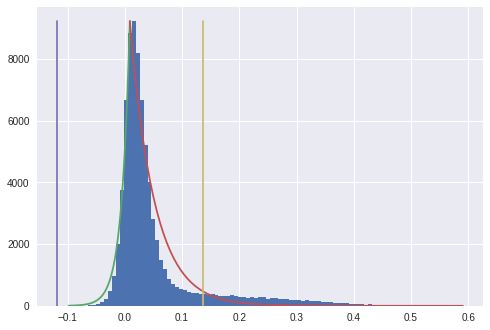

Got 1234 coords
After resolving overlaps, got 1234 seqlets
Across all tasks, the weakest laplace threshold used was: 0.948652384961491
1234 identified in total
Reducing weak_threshold_for_counting_sign to match laplace_threshold_cdf, from 0.99 to 0.948652384961491
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [1234]
Idx to activities:  {0: '1'}
On metacluster 0
Metacluster size 1234
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 1234
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings


Using TensorFlow backend.


Finished embedding computation in 0.84 s
Starting affinity matrix computations
Normalization computed in 0.06 s
Cosine similarity mat computed in 0.32 s
Normalization computed in 0.04 s
Cosine similarity mat computed in 0.3 s
Finished affinity matrix computations in 0.64 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.09 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job
Job completed in: 12.19 s
Launching nearest neighbors affmat calculation job
Job completed in: 6.0 s
(Round 1) Computed affinity matrix on nearest neighbors in 19.77 s
Filtered down to 1211 of 1234
(Round 1) Retained 1211 rows out of 1234 after filtering
(Round 1) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1211 samples in 0.001s...
[t-SNE] Computed neighbors for 1211 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1211
[t-SNE] Computed cond

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.1s finished


Louvain completed 200 runs in 7.222506523132324 seconds
Wrote graph to binary file in 0.6217403411865234 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.824862
After 41 runs, maximum modularity is Q = 0.837096
Louvain completed 91 runs in 3.221426486968994 seconds
Preproc + Louvain took 11.286661624908447 s
Got 11 clusters after round 1
Counts:
{7: 54, 1: 181, 2: 169, 4: 150, 9: 48, 3: 155, 0: 223, 5: 79, 6: 57, 8: 53, 10: 42}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 223 seqlets
Trimmed 1 out of 223
Skipped 1 seqlets
Aggregating for cluster 1 with 181 seqlets
Trimmed 17 out of 181
Skipped 5 seqlets
Aggregating for cluster 2 with 169 seqlets


/usr/local/lib/python3.6/dist-packages/modisco/core.py:972: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[:,None]),
/usr/local/lib/python3.6/dist-packages/modisco/core.py:974: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[::-1,None]),


Trimmed 9 out of 169
Skipped 5 seqlets
Aggregating for cluster 3 with 155 seqlets
Trimmed 3 out of 155
Skipped 4 seqlets
Aggregating for cluster 4 with 150 seqlets
Trimmed 1 out of 150
Aggregating for cluster 5 with 79 seqlets
Trimmed 0 out of 79
Aggregating for cluster 6 with 57 seqlets
Trimmed 0 out of 57
Skipped 1 seqlets
Aggregating for cluster 7 with 54 seqlets
Trimmed 0 out of 54
Aggregating for cluster 8 with 53 seqlets
Trimmed 2 out of 53
Aggregating for cluster 9 with 48 seqlets
Trimmed 0 out of 48
Aggregating for cluster 10 with 42 seqlets
Trimmed 1 out of 42
(Round 2) num seqlets: 1161
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.67 s
Starting affinity matrix computations
Normalization computed in 0.05 s
Cosine similarity mat computed in 0.27 s
Normalization computed in 0.05 s
Cosine similarity mat computed in 0.28 s
Finished affinity matrix computations in 0.57 s
(Round 2) Compute nearest neighbor

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.0s finished


Louvain completed 200 runs in 6.741260766983032 seconds
Wrote graph to binary file in 0.5844926834106445 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.83772
After 11 runs, maximum modularity is Q = 0.837936
Louvain completed 61 runs in 2.198561668395996 seconds
Preproc + Louvain took 9.735414028167725 s
Got 11 clusters after round 2
Counts:
{0: 221, 1: 158, 4: 149, 2: 155, 3: 149, 5: 79, 6: 56, 7: 54, 8: 51, 9: 48, 10: 41}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 221 seqlets
Trimmed 0 out of 221
Aggregating for cluster 1 with 158 seqlets
Trimmed 0 out of 158
Aggregating for cluster 2 with 155 seqlets
Trimmed 0 out of 155
Aggregating for cluster 3 with 149 seqlets
Trimmed 0 out of 149
Aggregating for cluster 4 with 149 seqlets
Trimmed 0 out of 149
Aggregating for cluster 5 with 79 seqlets
Trimmed 0 out of 79
Aggregating for cluster 6 with 56 seqlets
Trimmed 0 out of 56
Aggregating for cluster 7 with 54 seqle

In [12]:
import modisco
from importlib import reload
reload(modisco)
reload(modisco.tfmodisco_workflow)
reload(modisco.tfmodisco_workflow.workflow)
reload(modisco.aggregator)


#normalize the hyp scores such that, at each position, hypothetical importance
# scores that have the same sign as the original importance score all sum
# up to the original importance score value. The rationale is that if
# multiple different bases at a position could produce a similar score,
# the specific identity of each individual base is less important.
#Empirically, hypothetical scores like these appear to work better for
# motif discovery. Using normalized importance scores derived by taking
# the elementwise product of the normalized hypothetical scores and
# the one-hot encoding also seems to reduce noise.
normed_hyp_scores = []
normed_impscores = []
for i in range(len(impscores)):
  imp_score_each_pos = np.sum(impscores[i],axis=-1)
  imp_score_sign_each_pos = np.sign(imp_score_each_pos)
  hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])*imp_score_sign_each_pos[:,None] > 0)
  hyp_scores_same_sign_imp_scores_sum = np.sum(hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
  norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
  norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
  normed_hyp_scores.append(norm_hyp)
  normed_impscores.append(norm_hyp*onehot_data[i])
  
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                        #Adjust sliding_window_size and flank_size according to how big you expect
                        # the core motif to be; default values are 21 and 10
                        sliding_window_size=6,
                        flank_size=2,
                        #Unfortunately, at the time of writing,
                        # min_seqlets_per_task is not the actual number of seqlets
                        # that will end up being produced per task, but it
                        # serves as a rough target
                        #The reason for the difference is that many candidate seqlet windows
                        # will get discarded due to overlap with other windows
                        # and it's hard to predict how many
                        #The code is still in development, so I will likely
                        # refine this option later to correspond to the actual
                        # minimum number of seqlets produced per task
                        min_seqlets_per_task=3000,
                        seqlets_to_patterns_factory=modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Adjust trim_to_window_size and initial_flank_to_add
                        # according to how big you expect
                        # the core motif to be; default value is 10
                        trim_to_window_size=6,
                        initial_flank_to_add=2,
                        final_flank_to_add=5,
                        #kmer_len, num_gaps and num_mismatches are used to
                        # derive kmer embeddings for coarse-grained affinity
                        # matrix calculation. kmer_len=6, num_gaps=1
                        # and num_mismatches=0 means
                        # that kmer embeddings using 6-mers with 1 gap will be
                        # used.
                        kmer_len=6, num_gaps=1,
                        num_mismatches=0,
                        ),
                   )(
                task_names=["task0"],
                contrib_scores={'task0': normed_impscores},                
                hypothetical_contribs={'task0': normed_hyp_scores},
                one_hot=onehot_data)

num seqlets 592
fwd


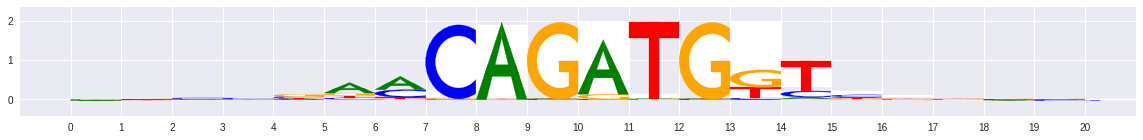

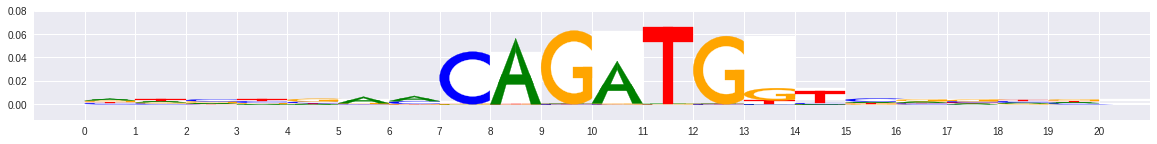

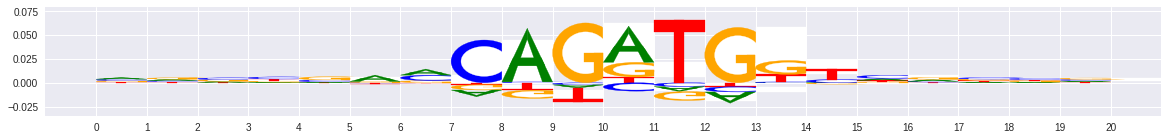

rev


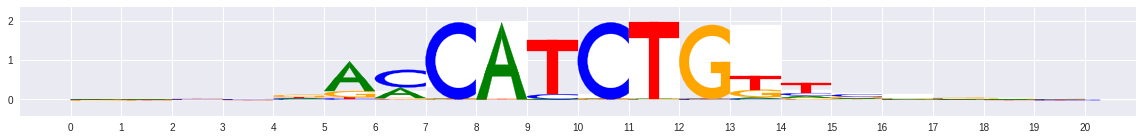

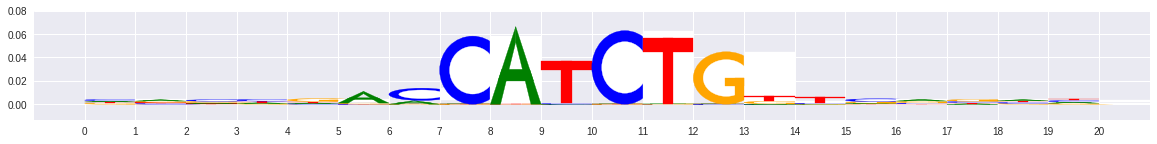

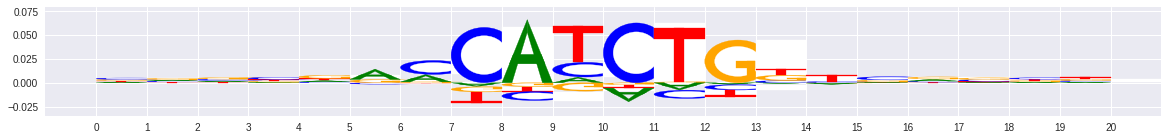

num seqlets 536
fwd


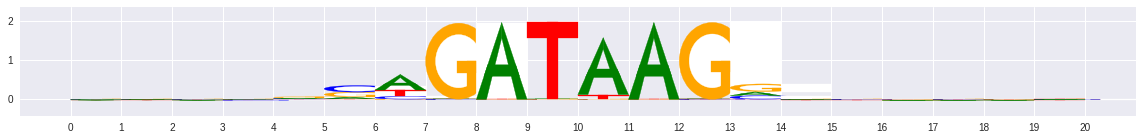

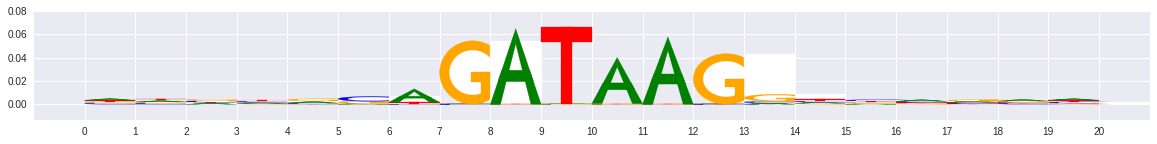

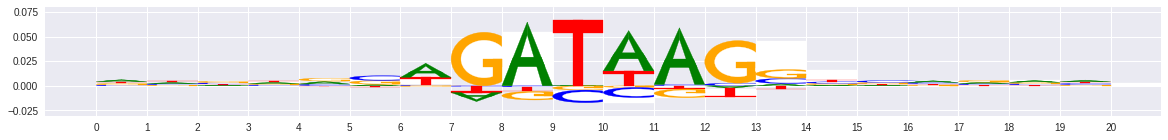

rev


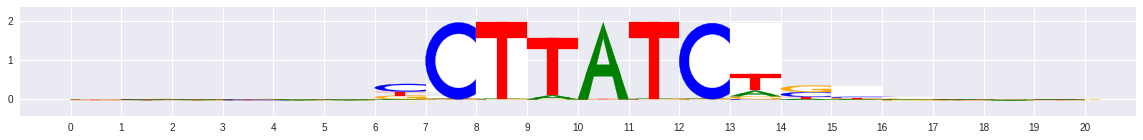

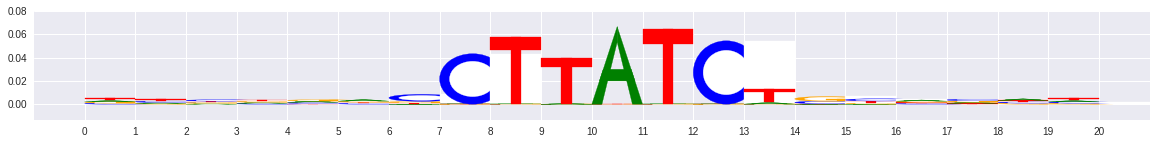

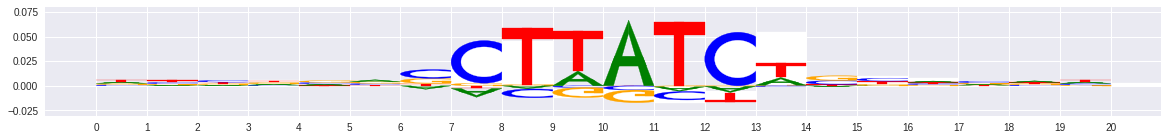

In [13]:
from modisco.visualization import viz_sequence

for i,pattern in enumerate(tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result.patterns):
  print("num seqlets",len(pattern.seqlets))
  print("fwd")
  viz_sequence.plot_weights(viz_sequence.ic_scale(
      pattern["sequence"].fwd, background=np.array([0.3,0.2,0.2,0.3])))
  viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
  
  print("rev")
  viz_sequence.plot_weights(viz_sequence.ic_scale(
      pattern["sequence"].rev, background=np.array([0.3,0.2,0.2,0.3])))
  viz_sequence.plot_weights(pattern["task0_contrib_scores"].rev)
  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)

In [0]:

def run_ism(model_file_path,sequence,temp_filepath):
  
  letter_to_idx = {'A':0, 'C':1, 'G':2, 'T':3, 'N': -1}
  
  fh = open(temp_filepath,'w')
  fh.write(">orig_seq\n")
  fh.write(sequence+"\n")
  fh.close()
  explanation_file = temp_filepath+".explanation.txt"
  !lsgkm/src/gkmexplain $temp_filepath $model_file_path $explanation_file
  
  gkmexplain_impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explanation_file)
  ][0]

  
  seq_len = len(sequence)
  fh = open(temp_filepath,'w')
  fh.write(">orig_seq\n")
  fh.write(sequence+"\n")
  
  onehot_seq = np.zeros((seq_len,4))  
  for pos in range(seq_len):
    orig_letter_idx = letter_to_idx[sequence[pos]]
    if (orig_letter_idx != -1):
      onehot_seq[pos,orig_letter_idx] = 1
    for letter in ['A','C','G','T']:
      #only need to compute scores for perturbations
      if (letter != sequence[pos]):
        letter_idx = letter_to_idx[letter]
        fh.write(">pos-"+str(pos)+"_base-"+str(letter_idx)+"\n")
        fh.write(sequence[:pos]+letter+sequence[pos+1:]+"\n")
  fh.close()
  
  predictions_file = temp_filepath+".preds.txt"
  !lsgkm/src/gkmpredict $temp_filepath $model_file_path $predictions_file
    
  ism_importance_scores = np.zeros((seq_len,4))
  for line in open(predictions_file):
    seq_name,pred = line.rstrip().split("\t")
    pred = float(pred)
    if (seq_name=="orig_seq"):
      orig_pred = pred
    else:
      pos,letter_idx = seq_name.split("_")
      pos = int(pos.split("-")[1])
      letter_idx = int(letter_idx.split("-")[1])
      ism_importance_scores[pos,letter_idx] = (pred - orig_pred)
  
  !rm $temp_filepath
  !rm $predictions_file
  !rm $explanation_file
  
  ism_hyp_importance_scores = ism_importance_scores-np.mean(ism_importance_scores,axis=1)[:,None]
  ism_importance_scores = ism_hyp_importance_scores*onehot_seq
  
  return ism_importance_scores, ism_hyp_importance_scores, gkmexplain_impscores
  


INFO 2018-10-15 04:31:28: Number of threads is set to 1
INFO 2018-10-15 04:31:28: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-15 04:31:28: reading... 1000/4452
INFO 2018-10-15 04:31:28: reading... 2000/4452
INFO 2018-10-15 04:31:29: reading... 3000/4452
INFO 2018-10-15 04:31:29: reading... 4000/4452
INFO 2018-10-15 04:31:29: write prediction result to tmp.explanation.txt
INFO 2018-10-15 04:31:29: 1 scored
INFO 2018-10-15 04:31:30: Number of threads is set to 1
INFO 2018-10-15 04:31:30: test log
INFO 2018-10-15 04:31:30: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-15 04:31:30: reading... 1000/4452
INFO 2018-10-15 04:31:30: reading... 2000/4452
INFO 2018-10-15 04:31:30: reading... 3000/4452
INFO 2018-10-15 04:31:31: reading... 4000/4452
INFO 2018-10-15 04:31:31: write prediction result to tmp.preds.txt
INFO 2018-10-15 04:31:31: 100 scored
INFO 2018-10-15 04:31:31: 200 scored
INFO 2018-10-15 04:31:32: 300 scored
INFO 2018-10-15 04:31:32: 400 scored
IN

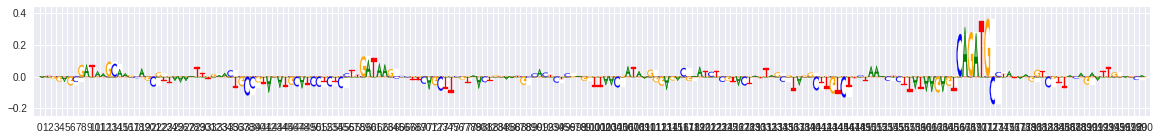

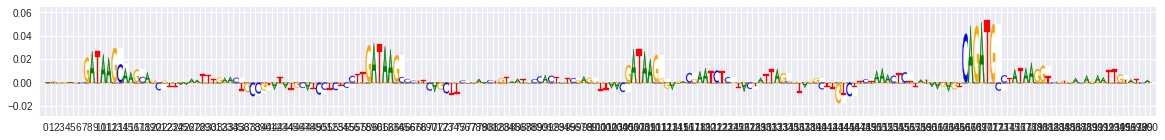

In [0]:
import time
#idx = 6
#the_seq = test_pos_seqs[idx]
the_seq = "ATGGAGCGATAAGCAAGCAGCGTTAAAATTTGAACTGCCGTATATGCATCCTCTCCTTGATAAGCCCTTCAGCTTCGTAACTGTAATGCCACTCTCGAGGTTAACGATAAGGGAGACGAATCTCGTACTATTAGCGTAGGCTTGTCTTCTAAACTCTTATAAGAGTCAGATGCCTATAAGGTCGTTACAGAATTGTATCA"

start = time.time()
ism_scores, ism_hyp_imp_scores, gkmexplain_scores = run_ism(model_file_path=model_file,
        sequence=the_seq, temp_filepath="tmp")
print(time.time()-start)

viz_sequence.plot_weights(ism_scores)
viz_sequence.plot_weights(gkmexplain_scores)

In [0]:
!python lsgkm/scripts/nrkmers.py 6 kmers.fa

In [0]:
!lsgkm/src/gkmpredict kmers.fa $model_file preds_kmers.txt

INFO 2018-10-08 05:01:43: Number of threads is set to 1
INFO 2018-10-08 05:01:43: test log
INFO 2018-10-08 05:01:43: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:01:44: reading... 1000/4452
INFO 2018-10-08 05:01:44: reading... 2000/4452
INFO 2018-10-08 05:01:44: reading... 3000/4452
INFO 2018-10-08 05:01:44: reading... 4000/4452
INFO 2018-10-08 05:01:44: write prediction result to preds_kmers.txt
INFO 2018-10-08 05:01:44: 100 scored
INFO 2018-10-08 05:01:44: 200 scored
INFO 2018-10-08 05:01:44: 300 scored
INFO 2018-10-08 05:01:44: 400 scored
INFO 2018-10-08 05:01:44: 500 scored
INFO 2018-10-08 05:01:44: 600 scored
INFO 2018-10-08 05:01:44: 700 scored
INFO 2018-10-08 05:01:44: 800 scored
INFO 2018-10-08 05:01:45: 900 scored
INFO 2018-10-08 05:01:45: 1000 scored
INFO 2018-10-08 05:01:45: 1100 scored
INFO 2018-10-08 05:01:45: 1200 scored
INFO 2018-10-08 05:01:45: 1300 scored
INFO 2018-10-08 05:01:45: 1400 scored
INFO 2018-10-08 05:01:45: 1500 scored
INFO 2018-10-08

In [0]:
deltasvm_kmer_to_pred = {}
rc_trans = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
for line in open("preds_kmers.txt"):
  kmer,pred = line.rstrip().split("\t")
  pred = float(pred)
  deltasvm_kmer_to_pred[kmer] = pred
  deltasvm_kmer_to_pred["".join([rc_trans[x] for x in kmer[::-1]])] = pred
  
def deltasvm_scores(sequence, deltasvm_kmer_to_pred, lmersize):
  
  onehot_sequence = np.zeros((len(sequence),4))
  scores = np.zeros((len(sequence),4))
  for (i,base) in enumerate(sequence):
    if (i <= len(sequence)-lmersize):
      lmer = sequence[i:i+lmersize]
      lmer_pred = deltasvm_kmer_to_pred[lmer]
      for (j,lmer_base) in enumerate(lmer):
        for base_idx,base_sub in enumerate(['A','C','G','T']):
          if base_sub!=lmer_base:
            new_lmer = lmer[:j]+base_sub+lmer[(j+1):]
            new_pred = deltasvm_kmer_to_pred[new_lmer]
            delta = new_pred - lmer_pred
            scores[i+j, base_idx] = delta
          else:
            onehot_sequence[i+j, base_idx] = 1
  scores = scores - np.mean(scores,axis=1)[:,None]
  return scores*onehot_sequence, scores
  

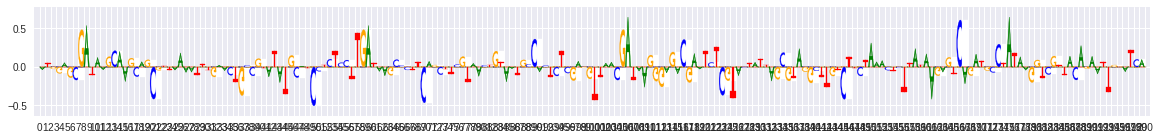

In [0]:
delta_svm_scores, delta_svm_hypscores = deltasvm_scores(the_seq, deltasvm_kmer_to_pred, 6)
viz_sequence.plot_weights(delta_svm_scores)

(200,)
200
(20, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:30:53: Number of threads is set to 1
INFO 2018-10-08 05:30:53: test log
INFO 2018-10-08 05:30:53: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:30:54: reading... 1000/4452
INFO 2018-10-08 05:30:54: reading... 2000/4452
INFO 2018-10-08 05:30:54: reading... 3000/4452
INFO 2018-10-08 05:30:54: reading... 4000/4452
INFO 2018-10-08 05:30:54: write prediction result to tmp_preds
INFO 2018-10-08 05:30:54: 20 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:30:55: Number of threads is set to 1
INFO 2018-10-08 05:30:55: test log
INFO 2018-10-08 05:30:55: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:30:55: reading... 1000/4452
INFO 2018-10-08 05:30:55: reading... 2000/4452
INFO 2018-10-08 05:30:56: reading... 3000/4452
INFO 2018-10-08 05:30:56: reading... 4000/4452
INFO 2018-10-08 05:30:56: write prediction result to tm

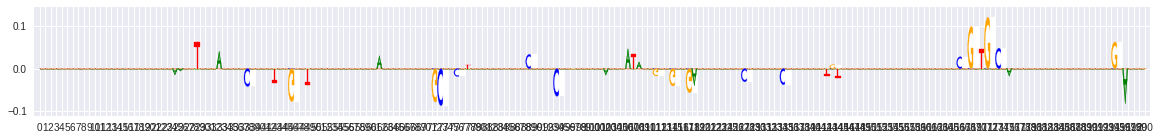

(200,)
1000
(20, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:31:12: Number of threads is set to 1
INFO 2018-10-08 05:31:12: test log
INFO 2018-10-08 05:31:12: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:31:12: reading... 1000/4452
INFO 2018-10-08 05:31:12: reading... 2000/4452
INFO 2018-10-08 05:31:12: reading... 3000/4452
INFO 2018-10-08 05:31:12: reading... 4000/4452
INFO 2018-10-08 05:31:12: write prediction result to tmp_preds
INFO 2018-10-08 05:31:13: 20 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:31:13: Number of threads is set to 1
INFO 2018-10-08 05:31:13: test log
INFO 2018-10-08 05:31:13: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:31:13: reading... 1000/4452
INFO 2018-10-08 05:31:13: reading... 2000/4452
INFO 2018-10-08 05:31:14: reading... 3000/4452
INFO 2018-10-08 05:31:14: reading... 4000/4452
INFO 2018-10-08 05:31:14: write prediction result to t

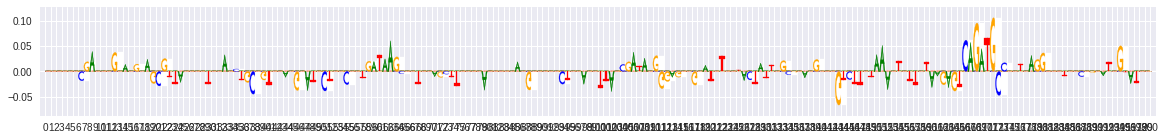

(200,)
2000
(20, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:32:07: Number of threads is set to 1
INFO 2018-10-08 05:32:07: test log
INFO 2018-10-08 05:32:07: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:32:07: reading... 1000/4452
INFO 2018-10-08 05:32:07: reading... 2000/4452
INFO 2018-10-08 05:32:08: reading... 3000/4452
INFO 2018-10-08 05:32:08: reading... 4000/4452
INFO 2018-10-08 05:32:08: write prediction result to tmp_preds
INFO 2018-10-08 05:32:08: 20 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:32:09: Number of threads is set to 1
INFO 2018-10-08 05:32:09: test log
INFO 2018-10-08 05:32:09: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:32:09: reading... 1000/4452
INFO 2018-10-08 05:32:09: reading... 2000/4452
INFO 2018-10-08 05:32:09: reading... 3000/4452
INFO 2018-10-08 05:32:10: reading... 4000/4452
INFO 2018-10-08 05:32:10: write prediction result to t

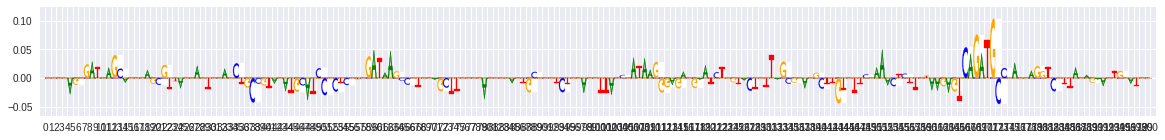

(200,)
4000
(20, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:33:50: Number of threads is set to 1
INFO 2018-10-08 05:33:50: test log
INFO 2018-10-08 05:33:50: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:33:50: reading... 1000/4452
INFO 2018-10-08 05:33:50: reading... 2000/4452
INFO 2018-10-08 05:33:51: reading... 3000/4452
INFO 2018-10-08 05:33:51: reading... 4000/4452
INFO 2018-10-08 05:33:51: write prediction result to tmp_preds
INFO 2018-10-08 05:33:51: 20 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:33:51: Number of threads is set to 1
INFO 2018-10-08 05:33:51: test log
INFO 2018-10-08 05:33:51: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:33:52: reading... 1000/4452
INFO 2018-10-08 05:33:52: reading... 2000/4452
INFO 2018-10-08 05:33:52: reading... 3000/4452
INFO 2018-10-08 05:33:52: reading... 4000/4452
INFO 2018-10-08 05:33:52: write prediction result to t

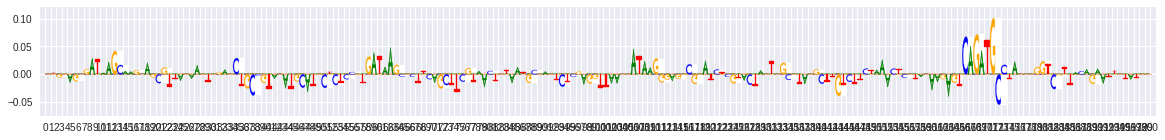

(200,)
10000
(20, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:37:06: Number of threads is set to 1
INFO 2018-10-08 05:37:06: test log
INFO 2018-10-08 05:37:06: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:37:06: reading... 1000/4452
INFO 2018-10-08 05:37:06: reading... 2000/4452
INFO 2018-10-08 05:37:07: reading... 3000/4452
INFO 2018-10-08 05:37:07: reading... 4000/4452
INFO 2018-10-08 05:37:07: write prediction result to tmp_preds
INFO 2018-10-08 05:37:07: 20 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:37:08: Number of threads is set to 1
INFO 2018-10-08 05:37:08: test log
INFO 2018-10-08 05:37:08: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:37:08: reading... 1000/4452
INFO 2018-10-08 05:37:08: reading... 2000/4452
INFO 2018-10-08 05:37:08: reading... 3000/4452
INFO 2018-10-08 05:37:09: reading... 4000/4452
INFO 2018-10-08 05:37:09: write prediction result to 

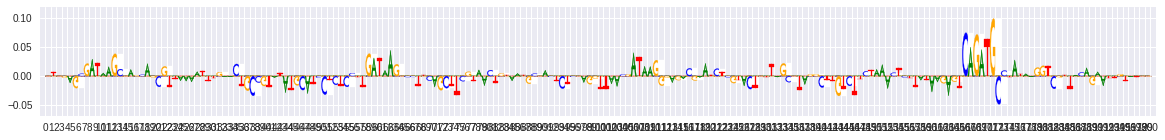

(200,)
20000
(20, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:45:48: Number of threads is set to 1
INFO 2018-10-08 05:45:48: test log
INFO 2018-10-08 05:45:48: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:45:49: reading... 1000/4452
INFO 2018-10-08 05:45:49: reading... 2000/4452
INFO 2018-10-08 05:45:49: reading... 3000/4452
INFO 2018-10-08 05:45:49: reading... 4000/4452
INFO 2018-10-08 05:45:49: write prediction result to tmp_preds
INFO 2018-10-08 05:45:50: 20 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:45:50: Number of threads is set to 1
INFO 2018-10-08 05:45:50: test log
INFO 2018-10-08 05:45:50: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:45:50: reading... 1000/4452
INFO 2018-10-08 05:45:51: reading... 2000/4452
INFO 2018-10-08 05:45:51: reading... 3000/4452
INFO 2018-10-08 05:45:51: reading... 4000/4452
INFO 2018-10-08 05:45:51: write prediction result to 

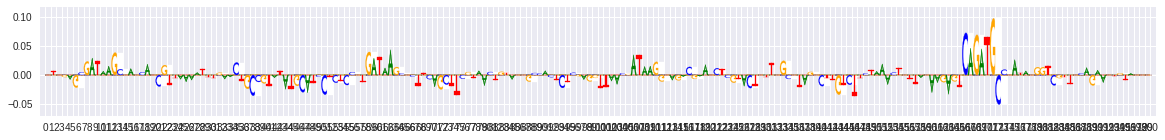

In [0]:
#!pip install shap

import shap
import numpy as np
import sys
import deeplift
from deeplift import dinuc_shuffle
import time
import random


def onehot_seq(seq):
  letter_to_index = {'A':0, 'a':0,
                     'C':1, 'c':1,
                     'G':2, 'g':2,
                     'T':3, 't':3}
  to_return = np.zeros((len(seq),4))
  for idx,letter in enumerate(seq):
    to_return[idx,letter_to_index[letter]] = 1
  return to_return


def get_shap_explanation(gkmsvm_model_path,
                         seq, background_seqs,
                         tempfile, nsamples):
  
  index_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
  letter_to_index = dict([(y,x) for (x,y) in index_to_letter.items()])
  
  def pred_func(numerically_encoded_seqs):
    print(numerically_encoded_seqs.shape)
    #convert the sequences to strings]
    seqs = ["".join(index_to_letter[x] for x in seq)
            for seq in numerically_encoded_seqs]
    
    fh = open(tempfile, "w");
    for i,seq in enumerate(seqs):
      fh.write(">seq"+str(i)+"\n")
      fh.write(seq+"\n")
    fh.close()
    
    model_preds = tempfile+"_preds"
    print(tempfile, gkmsvm_model_path, model_preds)
    
    !lsgkm/src/gkmpredict $tempfile $gkmsvm_model_path $model_preds
    
    return np.array([float(x.rstrip().split("\t")[1])
                     for x in open(model_preds)])
  
  
  X_test = np.array([letter_to_index[x] for x in seq])
  print(X_test.shape)
  print(nsamples)
  
  explainer = shap.KernelExplainer(pred_func,
                                   np.array(
                                   [[letter_to_index[x] for x in seq]
                                    for seq in background_seqs]
                                   ))
  shap_values = explainer.shap_values(X_test,
                                      nsamples=nsamples)
  return shap_values

nsamples_to_explanation = {}
nsamples_to_time_taken = {}

for nsamples_multiplier in [1,5,10,20,50,100]:

  n_bg = 20
  nsamples = len(the_seq)*nsamples_multiplier
  start = time.time()
  np.random.seed(1234)
  random.seed(1234)
  shap_explanation = get_shap_explanation(
      gkmsvm_model_path=model_file,
      seq=the_seq,
      background_seqs=[
          dinuc_shuffle.dinuc_shuffle(the_seq)
          for i in range(n_bg)],
      tempfile="tmp",
      nsamples=nsamples)
  
  time_taken = time.time() - start
  nsamples_to_time_taken[nsamples] = time_taken
  print("Time taken:",time_taken)  
  print("Num samples:",nsamples,"bg size",n_bg)
  explanation = shap_explanation[:,None]*onehot_seq(the_seq)
  nsamples_to_explanation[nsamples] = explanation
  viz_sequence.plot_weights(explanation)

200 samples time taken 13.993800640106201


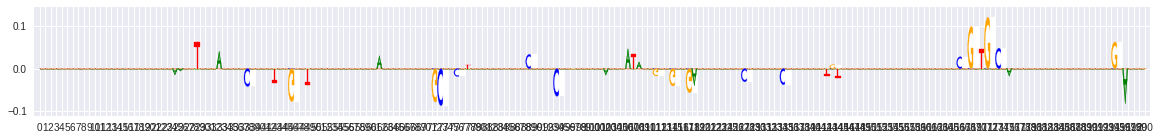

1000 samples time taken 51.557674169540405


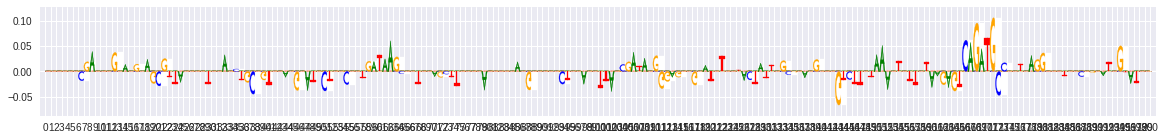

2000 samples time taken 98.82015037536621


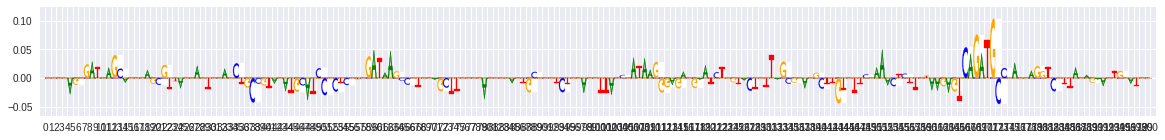

4000 samples time taken 192.0892825126648


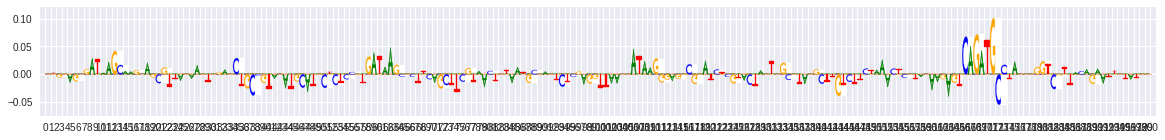

10000 samples time taken 518.153169631958


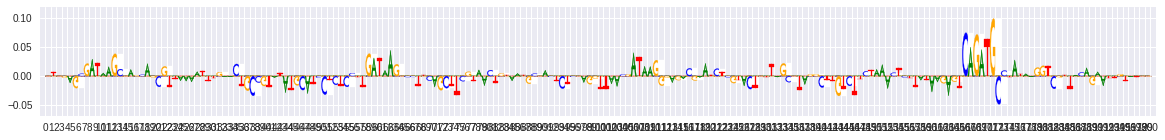

20000 samples time taken 971.4293189048767


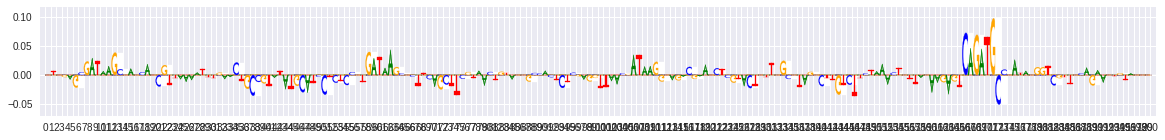

In [0]:
for nsamples in sorted(nsamples_to_explanation.keys()):
  print(nsamples,"samples","time taken",nsamples_to_time_taken[nsamples])
  viz_sequence.plot_weights(nsamples_to_explanation[nsamples])